In [1]:
import os
import sys
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from viz.graphs import plot_vertical_bars_errors, plot_heatmap, plot_bargraph, plot_bargraph_labels, plot_loglog
from viz.graphs import plot_histogram_bins, plot_vertical_bars
from viz.radar import Radar

%matplotlib inline

In [2]:
# Functions to load data from the csv files
def get_algo_names(csv_file):
    df = pd.read_csv(csv_file)
    return df['Algorithm']

def get_user_time(csv_file):
    df = pd.read_csv(csv_file)
    return df['User']

def get_real_time(csv_file):
    df = pd.read_csv(csv_file)
    return df['Real']

def get_sync_pr_user_time(col_name, csv_file):
    df = pd.read_csv(csv_file)
    col_filter = df['Algorithm'] == col_name
    filtered_df = df[col_filter]
    #print(len(filtered_df), len(df))
    return np.mean(filtered_df['User'].values[1:]), np.std(filtered_df['User'].values[1:])

def get_sync_pr_real_time(col_name, csv_file):
    df = pd.read_csv(csv_file)
    col_filter = df['Algorithm'] == col_name
    filtered_df = df[col_filter]
    return np.mean(filtered_df['User'].values[1:]), np.std(filtered_df['User'].values[1:])

def get_user_time_algos(algorithms, csv_file):
    df = pd.read_csv(csv_file)
    times = []
    errs = []
    for alg in algorithms:
        alg_filter = df['Algorithm'] == alg 
        filtered_df = df[alg_filter]
        time = np.mean(filtered_df['User'].values[1:])
        err = np.std(filtered_df['User'].values[1:])
        times += [time]
        errs += [err]
    return times, errs

def get_cache_data(csv_file):
    df = pd.read_csv(csv_file)
    unique_orderings = df.Ordering.unique()
    unique_algs = df.Algo.unique()
    unique_algs = sorted(unique_algs)
    data = []
    err_data = []
    for o in unique_orderings:
        if o == 'bfs':
            # We don't want to plot BFS ordering as this ordering is not available on all systems
            continue
        rows = df.loc[df['Ordering'] == o]
        ordering_data = []
        ordering_err_data = []
        for alg in unique_algs:
            refined_rows = rows.loc[rows['Algo'] == alg]
            miss_rates = refined_rows['Misses']/refined_rows['Refs']
            avg_rate = np.average(miss_rates)
            ordering_data += [avg_rate]
            ordering_err_data += [np.std(miss_rates)]
        data += [ordering_data]
        err_data += [ordering_err_data]
    return data, err_data

def get_sync_pr_cache_data(column, csv_file, orderings):
    result_dict = {}
    err_dict = {}
    df = pd.read_csv(csv_file)
    col_filter = df['Algo'] == column
    filtered_df = df[col_filter]
    for o in orderings:
        rows = filtered_df.loc[filtered_df['Ordering'] == o]
        miss_rates = rows['Misses']/rows['Refs']
        result_dict[o] = np.average(miss_rates)
        err_dict[o] = np.std(miss_rates)
    return result_dict, err_dict

def get_graphchi_pr_cache_data(algorithm,filename,orderings):
    df = pd.read_csv(filename)
    data_dict = {}
    err_dict = {}
    alg_filter = df["Algo"] == algorithm
    df = df[alg_filter]
    for o in orderings:
        ordering_filter = df["Ordering"] == o
        ordered_df = df[ordering_filter]
        filtered_data = ordered_df["Percentage"].values[1:]
        val = np.mean(filtered_data)
        err = np.std(filtered_data)
        data_dict[o] = val
        err_dict[o] = err
    return data_dict, err_dict

def get_galois_bfs_values(algorithm, filename, colname):
    data = pd.read_csv(filename)
    algorithms = get_algo_names(filename)
    algorithms = np.unique(algorithms)
    vertices = np.unique(data["Vertex_ID"])
    alg_filter = data["Algorithm"] == algorithm
    alg_data = data[alg_filter]
    nonzerodeg_filter = alg_data["Vertex_ID"] != 0
    zerodeg_filter = alg_data["Vertex_ID"] == 0
    nzdata = alg_data[nonzerodeg_filter]
    zdata = alg_data[zerodeg_filter]
    nz_value = np.mean(nzdata[colname].values)
    nz_err = np.std(nzdata[colname].values)
    z_value = np.mean(zdata[colname].values)
    z_err = np.std(zdata[colname].values)
    return nz_value, z_value
    

In [3]:
# Generic function to plot a graph vertically stacked bars
def vertical_stack_bars_errors(name, benchmark, files,title=""):
    orderings = ()
    dataset = ""
    for f in files:
        bname = os.path.basename(f)
        tokens = bname.split('-')
        dataset = bname.split('-')[0]
        ordering = bname.split('-')[1].split('.')[0]
        if dataset == "soc":
            ordering = bname.split('-')[2].split('.')[0]
        orderings = orderings + (ordering,)
    names_col = get_algo_names(files[0])
    names_col = np.unique(names_col)
    algorithms = ()
    for n in names_col:
        algorithms = algorithms + (n,)
    time_cols = []
    err_cols = []
    for f in files:
        time_col, err_col = get_user_time_algos(names_col, f)
        time_cols += [time_col]
        err_cols += [err_col]
    data = []
    err_data = []
    for i in range(len(orderings)):
        col = []
        err_col = []
        for t in time_cols[i]:
            col += [t]
        for e in err_cols[i]:
            err_col += [e]
        data += [col]
        err_data += [err_col]
    plot_vertical_bars_errors(name + "_" + benchmark + "_" + dataset, data, algorithms, orderings, "Runtime (in s)", (8,4), "Algorithms", err_data,title=title)

    
def plot_cache(name, csv_file,title=""):
    df = pd.read_csv(csv_file)
    unique_orderings = df.Ordering.unique()
    unique_algs = df.Algo.unique()
    unique_algs = sorted(unique_algs)
    data , err_data = get_cache_data(csv_file)
    plot_vertical_bars_errors(name, data, unique_algs, unique_orderings, "Cache Miss Rate", (8,4), "Algorithms", err_data,title=title)
    
    
def plot_bars_with_errors(name, benchmark, datafile_base, suffixes, title=""):
    files = []
    for s in suffixes:
        files += [datafile_base + s + "-" + benchmark + ".csv"]
    vertical_stack_bars_errors(name, benchmark, files, title)
    
def plot_comparison(name, isomorphism, datafile_base, benchmark):
    files = []
    files += [datafile_base + "-" + isomorphism + "-" + benchmark + ".csv"]
    files += [datafile_base + "-" + isomorphism + "_nz-" + benchmark + ".csv"]
    vertical_stack_bars_errors(name, benchmark + "-" + isomorphism + "comparison", files)

## Experiment - Vertex Isomorphism vs Algorithm choice

We use the various algorithm for PageRank and Connected Components on Galois as it has the widest variety of algorithms.

PageRank


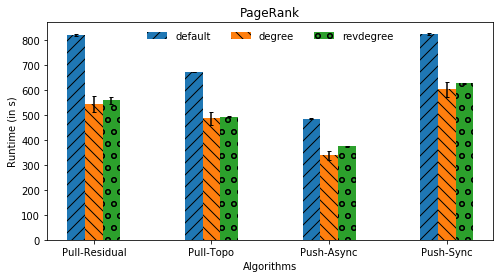

ConnectedComponents


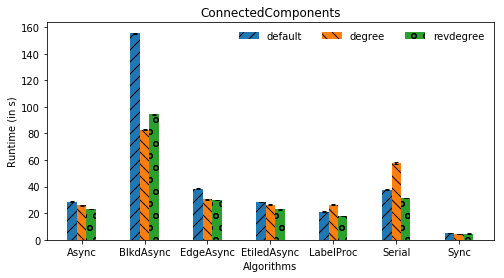

In [4]:
## Twitter
suffixes = ["-default", "-degree", "-revdegree"]
datafile_base = "../scripts/galois/stats/twitter_rv/twitter_rv"
benchmarks = ["pr", "cc"]
full_names = {"pr" : "PageRank", "cc" : "ConnectedComponents"}
for benchmark in benchmarks:
    print(full_names[benchmark])
    plot_bars_with_errors("galois", benchmark, datafile_base, suffixes, full_names[benchmark])
    plt.show()

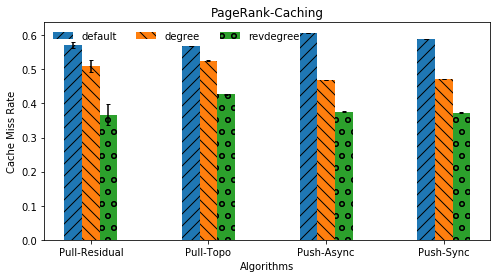

In [5]:
datafile = "../scripts/galois/stats/twitter_rv/twitter_rv_pr_cache.csv"
plot_cache('galois_twitter_rv_pr_cache', datafile, "PageRank-Caching")

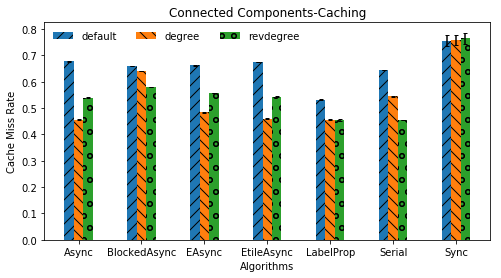

In [6]:
datafile = "../scripts/galois/stats/twitter_rv/twitter_rv_cc_cache.csv"
plot_cache('galois_twitter_rv_cc_cache', datafile, "Connected Components-Caching")

## Experiment - Vertex Ordering Impact Across System

We use the Push-Sync algorithm as this is the algorithm that has implementations across more systems.

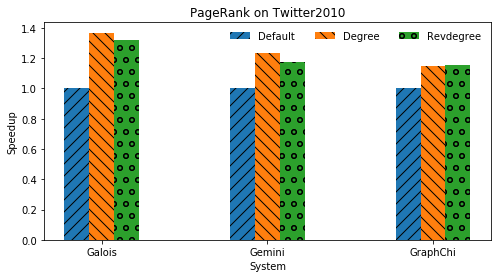

In [3]:
## Twitter
orderings = ["default", "degree", "revdegree"]
data = {}
data["default"] = []
data["degree"] = []
data["revdegree"] = []
err_data = {}
err_data["default"] = []
err_data["degree"] = []
err_data["revdegree"] = []
for o in orderings:
    galois_file = "../scripts/galois/stats/twitter_rv/twitter_rv" + "-" + o + "-pr" + ".csv"
    sync_data, err = get_sync_pr_user_time("Push-Sync", galois_file)
    #print(sync_data)
    data[o] += [sync_data]
    err_data[o] += [err]
    gemini_file = "../scripts/gemini/stats/twitter_rv/twitter_rv" + "-" + o + "-pr" + ".csv"
    sync_data, err = get_sync_pr_user_time("Sync", gemini_file)
    #print(sync_data)
    data[o] += [sync_data]
    err_data[o] += [err]
    graphchi_file = "../graphchi/twitter_rv/twitter_rv" + "-" + o + "-pr" + ".csv"
    sync_data, err = get_sync_pr_user_time("PR-Sync", graphchi_file)
    #print(sync_data)
    data[o] += [sync_data]
    err_data[o] += [err]
    
speedup_data = {}
speedup_data["default"] = []
speedup_data["degree"] = []
speedup_data["revdegree"] = []
for default, degree, rev in zip(data["default"], data["degree"], data["revdegree"]):
    speedup_data["default"] += [default/default]
    speedup_data["degree"] += [default/degree]
    speedup_data["revdegree"] += [default/rev]
    
data = []
data += [speedup_data["default"]]
data += [speedup_data["degree"]]
data += [speedup_data["revdegree"]]

plot_vertical_bars("twitter_pagerank_comparison", data, ["Galois", "Gemini", "GraphChi"], ["Default", "Degree", "Revdegree"], "Speedup", xlabel="System", title="PageRank on Twitter2010")

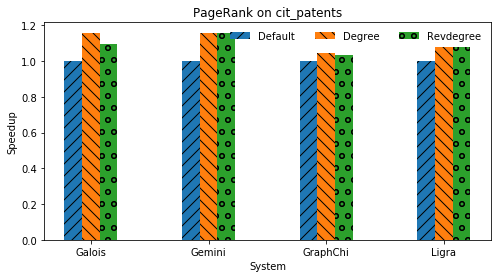

In [6]:
## Cit-Patents
orderings = ["default", "degree", "revdegree"]
data = {}
data["default"] = []
data["degree"] = []
data["revdegree"] = []
err_data = {}
err_data["default"] = []
err_data["degree"] = []
err_data["revdegree"] = []
for o in orderings:
    galois_file = "../scripts/galois/stats/cit_patents/cit_patents" + "-" + o + "-pr" + ".csv"
    sync_data, err = get_sync_pr_user_time("Push-Sync", galois_file)
    #print(sync_data)
    data[o] += [sync_data]
    err_data[o] += [err]
    gemini_file = "../scripts/gemini/stats/cit_patents/cit_patents" + "-" + o + "-pr" + ".csv"
    sync_data, err = get_sync_pr_user_time("Sync", gemini_file)
    #print(sync_data)
    data[o] += [sync_data]
    err_data[o] += [err]
    graphchi_file = "../graphchi/cit_patents/cit_patents" + "-" + o + "-pr" + ".csv"
    sync_data, err = get_sync_pr_user_time("PR-Sync", graphchi_file)
    #print(sync_data)
    data[o] += [sync_data]
    err_data[o] += [err]
    ligra_file = "../ligra_results/cit_patents/cit_patents" + "-" + o + "-pr" + ".csv"
    sync_data, err = get_sync_pr_user_time("Sync", ligra_file)
    data[o] += [sync_data]
    err_data[o] += err
    
speedup_data = {}
speedup_data["default"] = []
speedup_data["degree"] = []
speedup_data["revdegree"] = []
for default, degree, rev in zip(data["default"], data["degree"], data["revdegree"]):
    speedup_data["default"] += [default/default]
    speedup_data["degree"] += [default/degree]
    speedup_data["revdegree"] += [default/rev]
    
data = []
data += [speedup_data["default"]]
data += [speedup_data["degree"]]
data += [speedup_data["revdegree"]]

plot_vertical_bars("cit_patents_pagerank_comparison", data, ["Galois", "Gemini", "GraphChi", "Ligra"], ["Default", "Degree", "Revdegree"], "Speedup", xlabel="System", title="PageRank on cit_patents")

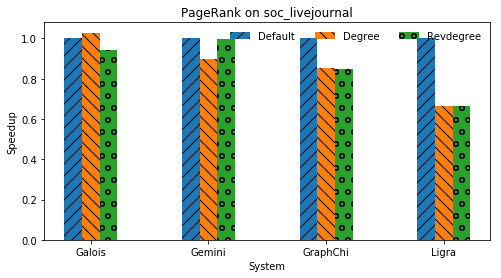

In [7]:
##Soc-Livejournal
orderings = ["default", "degree", "revdegree"]
data = {}
data["default"] = []
data["degree"] = []
data["revdegree"] = []
err_data = {}
err_data["default"] = []
err_data["degree"] = []
err_data["revdegree"] = []
for o in orderings:
    galois_file = "../scripts/galois/stats/soc_livejournal/soc-livejournal" + "-" + o + "-pr" + ".csv"
    sync_data, err = get_sync_pr_user_time("Push-Sync", galois_file)
    #print(sync_data)
    data[o] += [sync_data]
    err_data[o] += [err]
    gemini_file = "../scripts/gemini/stats/soc_livejournal/soc-livejournal" + "-" + o + "-pr" + ".csv"
    sync_data, err = get_sync_pr_user_time("Sync", gemini_file)
    #print(sync_data)
    data[o] += [sync_data]
    err_data[o] += [err]
    graphchi_file = "../graphchi/soc_livejournal/soc-livejournal" + "-" + o + "-pr" + ".csv"
    sync_data, err = get_sync_pr_user_time("PR-Sync", graphchi_file)
    #print(sync_data)
    data[o] += [sync_data]
    err_data[o] += [err]
    ligra_file = "../ligra_results/soc_livejournal/soc-livejournal" + "-" + o + "-pr" + ".csv"
    sync_data, err = get_sync_pr_user_time("Sync", ligra_file)
    data[o] += [sync_data]
    err_data[o] += err
    
speedup_data = {}
speedup_data["default"] = []
speedup_data["degree"] = []
speedup_data["revdegree"] = []
for default, degree, rev in zip(data["default"], data["degree"], data["revdegree"]):
    speedup_data["default"] += [default/default]
    speedup_data["degree"] += [default/degree]
    speedup_data["revdegree"] += [default/rev]
    
data = []
data += [speedup_data["default"]]
data += [speedup_data["degree"]]
data += [speedup_data["revdegree"]]

plot_vertical_bars("soc_livejournal_pagerank_comparison", data, ["Galois", "Gemini", "GraphChi", "Ligra"], ["Default", "Degree", "Revdegree"], "Speedup", xlabel="System", title="PageRank on soc_livejournal")

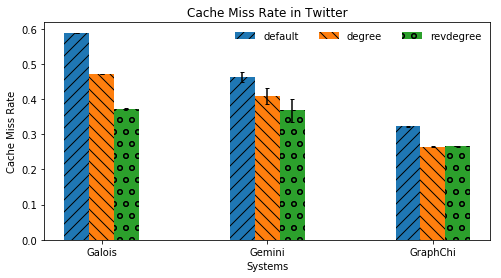

In [36]:
## Twitter Cache
orderings = ["default", "degree", "revdegree"]
data = {}
data["default"] = []
data["degree"] = []
data["revdegree"] = []
err_data = {}
err_data["default"] = []
err_data["degree"] = []
err_data["revdegree"] = []
result, errs = get_sync_pr_cache_data("Push-Sync","../scripts/galois/stats/twitter_rv/twitter_rv_pr_cache.csv",orderings)
for r, v in result.items():
    data[r] += [v]
for e, v in errs.items():
    err_data[e] += [v]
result, errs = get_sync_pr_cache_data("Sync", "../scripts/gemini/stats/twitter_rv/twitter_rv_pr_cache.csv", orderings)
for r, v in result.items():
    data[r] += [v]
for e, v in errs.items():
    err_data[e] += [v]
result, errs = get_graphchi_pr_cache_data("PR-Sync", "../scripts/graphchi/stats/twitter_rv/graphchi_twitter_cache_pr.csv", orderings)
for r, v in result.items():
    data[r] += [v]
for e, v in errs.items():
    err_data[e] += [v]
    
plot_data = []
plot_data += [data["default"]]
plot_data += [data["degree"]]
plot_data += [data["revdegree"]]

plot_err_data = []
plot_err_data += [err_data["default"]]
plot_err_data += [err_data["degree"]]
plot_err_data += [err_data["revdegree"]]

plot_vertical_bars_errors("twitter_cache_miss_rate", plot_data, ["Galois", "Gemini", "GraphChi"],orderings, "Cache Miss Rate", (8,4), "Systems", plot_err_data,title="Cache Miss Rate in Twitter")

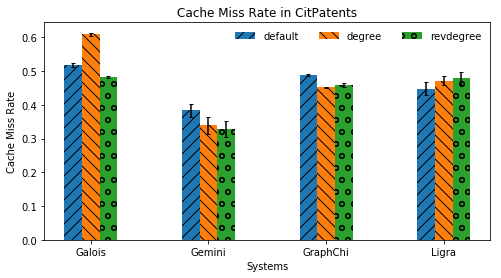

In [41]:
## CitPatents Cache
orderings = ["default", "degree", "revdegree"]
data = {}
data["default"] = []
data["degree"] = []
data["revdegree"] = []
err_data = {}
err_data["default"] = []
err_data["degree"] = []
err_data["revdegree"] = []
result, errs = get_sync_pr_cache_data("Push-Sync","../scripts/galois/stats/cit_patents/cit_patents_pr_cache.csv",orderings)
for r, v in result.items():
    data[r] += [v]
for e, v in errs.items():
    err_data[e] += [v]
result, errs = get_sync_pr_cache_data("Sync", "../scripts/gemini/stats/cit_patents/cit_patents_pr_cache.csv", orderings)
for r, v in result.items():
    data[r] += [v]
for e, v in errs.items():
    err_data[e] += [v]
result, errs = get_sync_pr_cache_data("PR-Sync", "../scripts/cit_patents-graphchi-pr_cache.csv", orderings)
for r, v in result.items():
    data[r] += [v]
for e, v in errs.items():
    err_data[e] += [v]
result, errs = get_sync_pr_cache_data("PR", "../scripts/cit_patents_ligra-pr_cache.csv", orderings)
for r,v in result.items():
    data[r] += [v]
for e,v in errs.items():
    err_data[e] += [v]
    
plot_data = []
plot_data += [data["default"]]
plot_data += [data["degree"]]
plot_data += [data["revdegree"]]

plot_err_data = []
plot_err_data += [err_data["default"]]
plot_err_data += [err_data["degree"]]
plot_err_data += [err_data["revdegree"]]

plot_vertical_bars_errors("cit_patents_cache_miss_rate", plot_data, ["Galois", "Gemini", "GraphChi", "Ligra"],orderings, "Cache Miss Rate", (8,4), "Systems", plot_err_data,title="Cache Miss Rate in CitPatents")

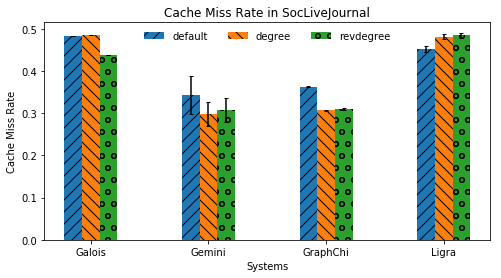

In [43]:
## SocLiveJournal Cache
orderings = ["default", "degree", "revdegree"]
data = {}
data["default"] = []
data["degree"] = []
data["revdegree"] = []
err_data = {}
err_data["default"] = []
err_data["degree"] = []
err_data["revdegree"] = []
result, errs = get_sync_pr_cache_data("Push-Sync","../scripts/galois/stats/soc_livejournal/soc-livejournal-pr_cache.csv",orderings)
for r, v in result.items():
    data[r] += [v]
for e, v in errs.items():
    err_data[e] += [v]
result, errs = get_sync_pr_cache_data("Sync", "../scripts/gemini/stats/soc_livejournal/soc-livejournal_pr_cache.csv", orderings)
for r, v in result.items():
    data[r] += [v]
for e, v in errs.items():
    err_data[e] += [v]
result, errs = get_sync_pr_cache_data("PR-Sync", "../scripts/soclj-graphchi-pr_cache.csv", orderings)
for r, v in result.items():
    data[r] += [v]
for e, v in errs.items():
    err_data[e] += [v]
result, errs = get_sync_pr_cache_data("PR", "../scripts/soclj_ligra-pr_cache.csv", orderings)
for r,v in result.items():
    data[r] += [v]
for e,v in errs.items():
    err_data[e] += [v]
    
plot_data = []
plot_data += [data["default"]]
plot_data += [data["degree"]]
plot_data += [data["revdegree"]]

plot_err_data = []
plot_err_data += [err_data["default"]]
plot_err_data += [err_data["degree"]]
plot_err_data += [err_data["revdegree"]]

plot_vertical_bars_errors("soc_livejournal_cache_miss_rate", plot_data, ["Galois", "Gemini", "GraphChi", "Ligra"],orderings, "Cache Miss Rate", (8,4), "Systems", plot_err_data,title="Cache Miss Rate in SocLiveJournal")

## BFS Experiments

[5.9843335103558157, 5.9339682539682546, 10.063413158408926]
[1.0, 1.0, 1.0]


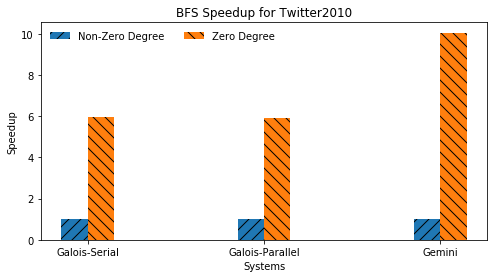

In [55]:
## Twitter Zero vs Non-Zero
Zero_speedup = []
NZ_speedup = []

nz_data, z_data = get_galois_bfs_values("Sync","../scripts/galois/stats/twitter_rv/twitter_rv-default-bfs-serial-sanitized.csv", "User")
Zero_speedup += [nz_data/z_data]
NZ_speedup += [nz_data/nz_data]
nz_data, z_data = get_galois_bfs_values("Sync", "../scripts/galois/stats/twitter_rv/twitter_rv-default-bfs-parallel-sanitized.csv", "User")
Zero_speedup += [nz_data/z_data]
NZ_speedup += [nz_data/nz_data]

#Gemini Data
filename = "../scripts/gemini/stats/twitter_rv/twitter_rv-default-bfs.csv"
column = "Exec"
alg_data = pd.read_csv(filename)
nonzerodeg_filter = alg_data["Vertex_ID"] != 0
zerodeg_filter = alg_data["Vertex_ID"] == 0
nzdata = alg_data[nonzerodeg_filter]
zdata = alg_data[zerodeg_filter]
nz_value = np.mean(nzdata[column].values)
nz_err = np.std(nzdata[column].values)
z_value = np.mean(zdata[column].values)
z_err = np.std(zdata[column].values)
gemini_speedup = nz_value / z_value
Zero_speedup += [nz_value/z_value]
NZ_speedup += [nz_value/nz_value]

print(Zero_speedup)
print(NZ_speedup)
data = []
data += [NZ_speedup]
data += [Zero_speedup]
plot_vertical_bars("twitter_bfs_comparison", data, ["Galois-Serial", "Galois-Parallel", "Gemini"], ["Non-Zero Degree", "Zero Degree"], "Speedup", (8,4), "Systems",title="BFS Speedup for Twitter2010")

## Experiment: Speedup in generated graphs

Scale vs SpeedUp for RMAT graphs

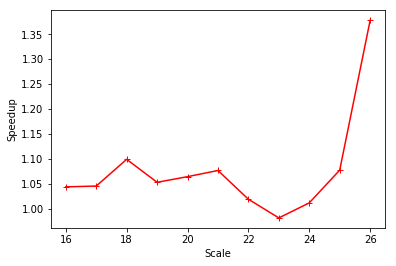

In [64]:
numbers = []
for i in range(16,27):
    numbers += [i]
speedup = {}
speedup["pr"] = []
speedup["tc"] = []
algorithms = ['pr', 'tc']
for n in numbers:
    for a in algorithms:
        filename = "../gengraph_collected_runtime/s" + str(n) + "_stats/graph_s" + str(n) + "_e16_" + a + "_runtime"
        packed_filename = filename + "_packed"
        unpacked_data = get_real_time(filename)
        packed_data = get_real_time(packed_filename)
        unpacked_mean = np.mean(unpacked_data[1:])
        packed_mean = np.mean(packed_data[1:])
        speedup_val = unpacked_mean/packed_mean
        speedup[a] += [speedup_val]

#plt.plot(numbers, speedup['pr'], label='PageRank', marker = '.', color='blue')
plt.plot(numbers, speedup['tc'], label='Triangle Counting', marker='+', color='red')
plt.xlabel('Scale')
plt.ylabel('Speedup')
#plt.legend()
plt.show()
plt.savefig('rmat_scale_packed_comparison.png')

## Experiment: Zero Vertices on PageRank and Connected Components for Twitter & Cit

In [65]:
## Twitter
## Galois
default_speedup = []
default_nz_speedup = []
o = "default"
o_nz = o + "_nz"
galois_file = "../scripts/galois/stats/twitter_rv/twitter_rv" + "-" + o + "-pr" + ".csv"
sync_data, err = get_sync_pr_user_time("Push-Sync", galois_file)
galois_nz_file = "../scripts/galois/stats/twitter_rv/twitter_rv" + "-" + o_nz + "-pr" + ".csv"
nz_sync_data, nz_err = get_sync_pr_user_time("Push-Sync", galois_nz_file)
default_speedup += [sync_data/sync_data]
default_nz_speedup += [sync_data/nz_sync_data]
#gemini_file = "../scripts/gemini/stats/twitter_rv/twitter_rv" + "-" + o + "-pr" + ".csv"
#sync_data, err = get_sync_pr_user_time("Sync", gemini_file)
#gemini_nz_file = "../scripts/gemini/stats/twitter_rv/twitter_rv" + "-" + o_nz + "-pr" + ".csv"
#nz_sync_data, err = get_sync_pr_user_time("Sync", gemini_nz_file)
#default_speedup += [sync_data/sync_data]
#default_nz_speedup += [sync_data/nz_sync_data]
graphchi_file = "../graphchi/twitter_rv/twitter_rv" + "-" + o + "-pr" + ".csv"
sync_data, err = get_sync_pr_user_time("PR-Sync", graphchi_file)
graphchi_nz_file = "../graphchi/twitter_rv/twitter_rv" + "-" + o_nz + "-pr" + ".csv"
nz_sync_data, err = get_sync_pr_user_time("PR-Sync", graphchi_nz_file)
default_speedup += [sync_data/sync_data]
default_nz_speedup += [sync_data/nz_sync_data]
print(default_speedup)
print(default_nz_speedup)

[1.0, 1.0, 1.0]
[1.0230855864594635, nan, 1.0802743117369229]


/home/vaastav/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/vaastav/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/vaastav/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/vaastav/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[1.0, 1.0, 1.0]
[1.0860121633362294, 1.1380137747167292, 1.0493011774909105]


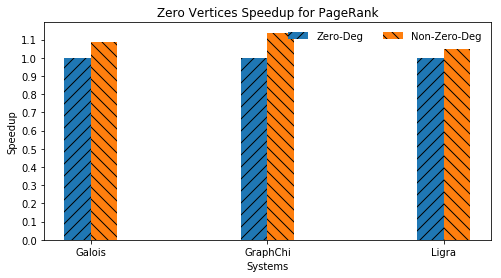

In [3]:
## Cit-Patents - PR
default_speedup = []
default_nz_speedup = []
speedup_dict = {}
o = "default"
o_nz = o + "_nz"
galois_file = "../scripts/galois/stats/cit_patents/cit_patents" + "-" + o + "-pr" + ".csv"
sync_data, err = get_sync_pr_real_time("Push-Sync", galois_file)
galois_nz_file = "../scripts/galois/stats/cit_patents/cit_patents" + "-" + o_nz + "-pr" + ".csv"
nz_sync_data, err = get_sync_pr_real_time("Push-Sync", galois_nz_file)
default_speedup += [sync_data/sync_data]
default_nz_speedup += [sync_data/nz_sync_data]
#gemini_file = "../scripts/gemini/stats/cit_patents/cit_patents" + "-" + o + "-pr" + ".csv"
#sync_data, err = get_sync_pr_real_time("Sync", gemini_file)
#gemini_nz_file = "../scripts/gemini/stats/cit_patents/cit_patents" + "-" + o_nz + "-pr" + ".csv"
#nz_sync_data, err = get_sync_pr_real_time("Sync", gemini_nz_file)
#default_speedup += [sync_data/sync_data]
#default_nz_speedup += [sync_data/nz_sync_data]
graphchi_file = "../graphchi/cit_patents/cit_patents" + "-" + o + "-pr" + ".csv"
sync_data, err = get_sync_pr_real_time("PR-Sync", graphchi_file)
graphchi_nz_file = "../graphchi/cit_patents/cit_patents" + "-" + o_nz + "-pr" + ".csv"
nz_sync_data, err = get_sync_pr_real_time("PR-Sync", graphchi_nz_file)
default_speedup += [sync_data/sync_data]
default_nz_speedup += [sync_data/nz_sync_data]
ligra_file = "../ligra_results/cit_patents/cit_patents" + "-" + o + "-pr" + ".csv"
sync_data, err = get_sync_pr_real_time("Sync", ligra_file)
ligra_nz_file = "../ligra_results/cit_patents/cit_patents" + "-" + o_nz + "-pr" + ".csv"
nz_sync_data, err = get_sync_pr_real_time("Sync", ligra_nz_file)
default_speedup += [sync_data/sync_data]
default_nz_speedup += [sync_data/nz_sync_data]
print(default_speedup)
print(default_nz_speedup)
data = []
data += [default_speedup]
data += [default_nz_speedup]
plot_vertical_bars("cit_patents_pr_nz_comparison", data, ["Galois", "GraphChi", "Ligra"], ["Zero-Deg", "Non-Zero-Deg"],"Speedup", (8,4), "Systems",title="Zero Vertices Speedup for PageRank", yticks=np.arange(0, 1.2, step=0.1))

[1.0, 1.0, 1.0]
[1.1352785145888595, 1.0420214665689205, 1.0886169818316649]


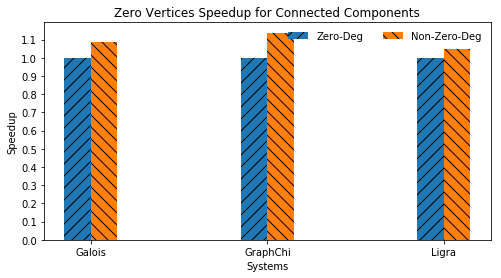

In [4]:
## Cit-Patents - PR
default_speedup = []
default_nz_speedup = []
speedup_dict = {}
o = "default"
o_nz = o + "_nz"
galois_file = "../scripts/galois/stats/cit_patents/cit_patents" + "-" + o + "-cc" + ".csv"
sync_data, err = get_sync_pr_user_time("Sync", galois_file)
galois_nz_file = "../scripts/galois/stats/cit_patents/cit_patents" + "-" + o_nz + "-cc" + ".csv"
nz_sync_data, err = get_sync_pr_user_time("Sync", galois_nz_file)
default_speedup += [sync_data/sync_data]
default_nz_speedup += [sync_data/nz_sync_data]
#gemini_file = "../scripts/gemini/stats/cit_patents/cit_patents" + "-" + o + "-cc" + ".csv"
#sync_data, err = get_sync_pr_user_time("Connected", gemini_file)
#gemini_nz_file = "../scripts/gemini/stats/cit_patents/cit_patents" + "-" + o_nz + "-cc" + ".csv"
#nz_sync_data, err = get_sync_pr_user_time("Connected", gemini_nz_file)
#default_speedup += [sync_data/sync_data]
#default_nz_speedup += [sync_data/nz_sync_data]
graphchi_file = "../graphchi/cit_patents/cit_patents" + "-" + o + "-cc" + ".csv"
sync_data, err = get_sync_pr_user_time("CC", graphchi_file)
graphchi_nz_file = "../graphchi/cit_patents/cit_patents" + "-" + o_nz + "-cc" + ".csv"
nz_sync_data, err = get_sync_pr_user_time("CC", graphchi_nz_file)
default_speedup += [sync_data/sync_data]
default_nz_speedup += [sync_data/nz_sync_data]
ligra_file = "../ligra_results/cit_patents/cit_patents" + "-" + o + "-cc" + ".csv"
sync_data, err = get_sync_pr_user_time("Sync", ligra_file)
ligra_nz_file = "../ligra_results/cit_patents/cit_patents" + "-" + o_nz + "-cc" + ".csv"
nz_sync_data, err = get_sync_pr_user_time("Sync", ligra_nz_file)
default_speedup += [sync_data/sync_data]
default_nz_speedup += [sync_data/nz_sync_data]
print(default_speedup)
print(default_nz_speedup)
plot_vertical_bars("cit_patents_cc_nz_comparison", data, ["Galois", "GraphChi", "Ligra"], ["Zero-Deg", "Non-Zero-Deg"],"Speedup", (8,4), "Systems",title="Zero Vertices Speedup for Connected Components", yticks=np.arange(0, 1.2, step=0.1))